In [2]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2


In [3]:
dataset = ToyGraspDataset(root='data', size=1200)
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks

dataset2 = ToyGraspDataset(root='data', size=1200)
data2 = dataset2.data
pos_masks2 = data2[:,2] == 1
neg_masks2 = ~pos_masks2
# handle_masks = data[:,3] == 1

In [4]:
# load pos vs neg classifier
f = ClassifierNN([2, 64, 64, 1])
f, info = load_model_info('pos_vs_neg', f)
f = f.to(device)

0.0 0.999619


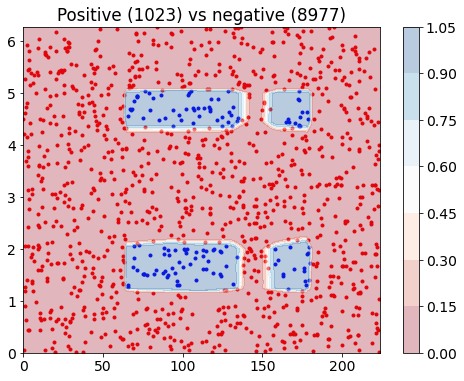

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)

ax.set_title(f'Positive ({int(info["pos_samples_size"])}) vs negative ({int(info["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

-7.8725634 568.2994


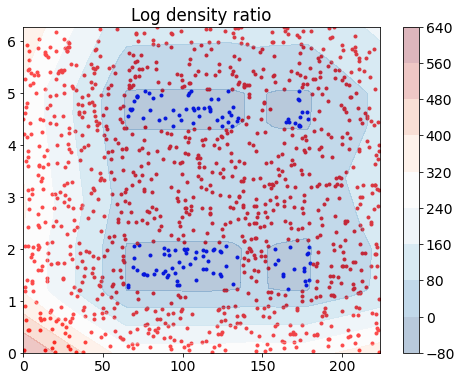

In [6]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05)

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [95]:
# refine samples
my_sample = torch.FloatTensor([[25, 0.3],
                               [210, 3]])#[160, 3]
my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

In [98]:
steps_refinement = 100
# print(info['pos_samples_size'], info['neg_samples_size'])
# print(f)
# print(my_sample)
all_x1, all_v1 = refine_sample(my_sample.to(device), f, steps=steps_refinement,
                               eta=0.00001, noise_factor=0.001,
                              Nq = info['pos_samples_size'], Np = info['neg_samples_size'])

  0%|          | 0/100 [00:00<?, ?it/s]

-0.89507234 64.76581


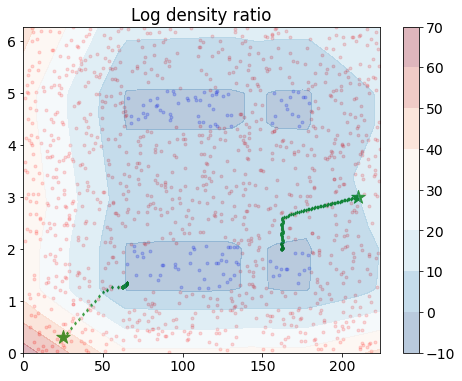

In [99]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)

Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                      Np=info['neg_samples_size'], Nq=info['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Sim+ vs Real+

In [1]:
# load sim vs real classifier
# f2 = ClassifierNN([2, 32, 1])
f2 = ClassifierNN([2, 64, 64, 1])
f2, info2 = load_model_info('simvsreal', f2)
f2 = f2.to(device)

NameError: name 'ClassifierNN' is not defined

0.0 0.9989982


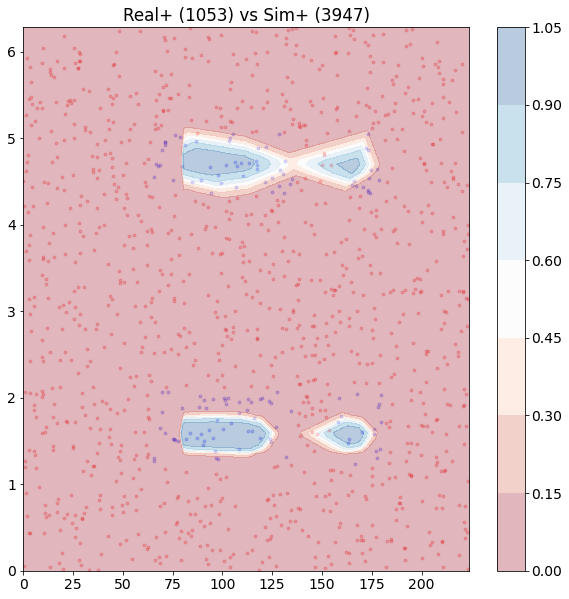

In [101]:
fig, ax = plt.subplots(nrows=1, figsize=(10,10))
# ax.scatter(data[handle_masks][:,0], data[handle_masks][:,1], marker='.', alpha=1.0, color='b')
# ax.scatter(data[~handle_masks][:,0], data[~handle_masks][:,1], marker='.', alpha=1.0, color='r')
ax.scatter(data2[pos_masks2][:,0], data2[pos_masks2][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data2[neg_masks2][:,0], data2[neg_masks2][:,1], marker='.', alpha=0.2, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)




ax.set_title(f'Real+ ({int(info2["pos_samples_size"])}) vs Sim+ ({int(info2["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [102]:
steps_refinement = 100
all_x1, all_v1 = refine_sample(my_sample.to(device), f2, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = info2['pos_samples_size'], Np = info2['neg_samples_size'])

  0%|          | 0/100 [00:00<?, ?it/s]

-1.8421348 50.06938


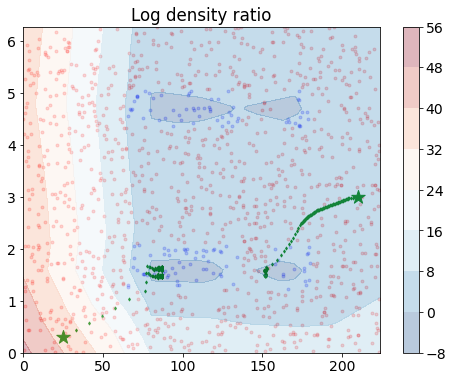

In [103]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
# ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')
ax.scatter(data2[pos_masks2][:,0], data2[pos_masks2][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data2[neg_masks2][:,0], data2[neg_masks2][:,1], marker='.', alpha=0.2, color='r')
plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)


Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np=info2['neg_samples_size'], Nq=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

### Multiple classifiers

In [75]:
steps_refinement = 100
all_x8, all_v8 = refine_sample2(my_sample.to(device), f, f2,
                                steps=steps_refinement,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
all_x8 = torch.cat(all_x8).numpy()

  0%|          | 0/100 [00:00<?, ?it/s]

In [76]:
# Np1=info['neg_samples_size'],
#                                 Nq1=info['pos_samples_size'],
#                                 Np2=info2['neg_samples_size'],
#                                 Nq2=info2['pos_samples_size']

-11.699127 110645.01


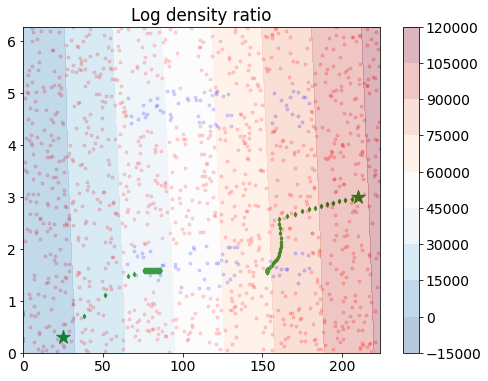

In [77]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# for i in range(1, steps_refinement, 1):
plt.scatter(all_x8[:,0]*224, all_x8[:,1]*(2*3.14), marker='d', color='g', s=10)

Z, CS = draw_density_ratio2(ax=ax,
                   model1=f,
                   model2=f2,
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np1=info['neg_samples_size'],
                   Nq1=info['pos_samples_size'],
                   Np2=info2['neg_samples_size'],
                   Nq2=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [78]:
item = load_item('fork')

In [79]:
# from matplotlib.patches import ArrowStyle
from matplotlib import animation
# arrow_style = ArrowStyle("Simple", head_length=.6, head_width=1.0, tail_width=.1)
from matplotlib.patches import Arrow

In [18]:
%matplotlib notebook

In [19]:
sample_stream = all_x8[1::2]

<IPython.core.display.Javascript object>


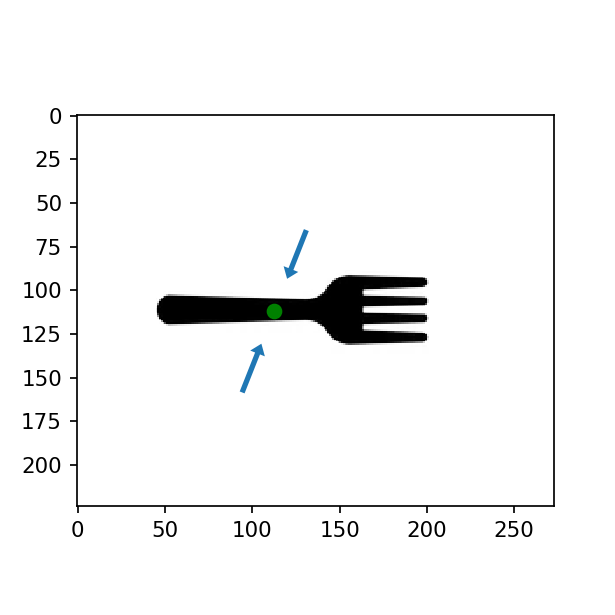

In [20]:
# def animate_grasp(sample_stream, fname):
fname = 'bad_to_pos_handle'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()

In [21]:
sample_stream = all_x8[::2]

<IPython.core.display.Javascript object>


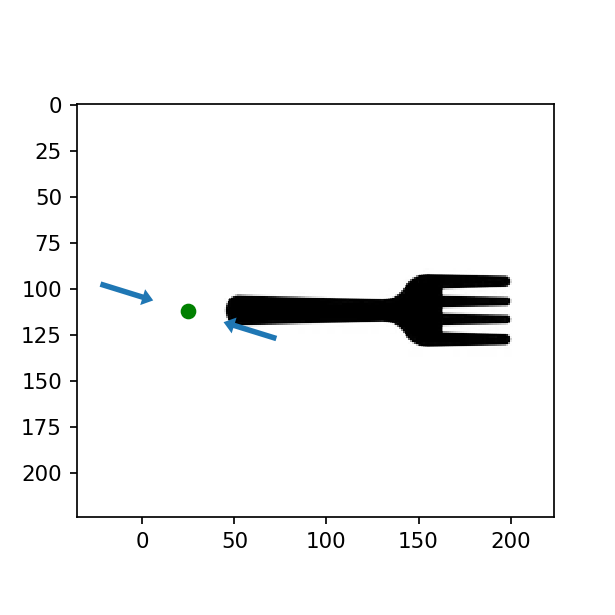

In [22]:
# def animate_grasp(sample_stream, fname):
fname = 'neg_to_pos'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()